### Loading data

Below we have the code that retrieves the data from the  Mechanical Turk Tracker Demographics API.

In [1]:
import pandas as pd
df = pd.read_csv("mturk_surveys.csv")
df.drop(df.columns[0], axis=1, inplace=True) # drop the "index" column
# We now transform our API answer into a flat table
# and set the right data types
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df["hit_creation_date"]=pd.to_datetime(df["hit_creation_date"])
df["household_income"]=df["household_income"].astype("category")
df["household_size"]=df["household_size"].astype("category")
df["location_country"]=df["location_country"].astype("category")
df["marital_status"]=df["marital_status"].astype("category")
df['date'] = df['hit_answered_date'].apply(lambda x : x.date())
df['time'] = df['hit_answered_date'].apply(lambda x : x.time())
df.dtypes

gender                             object
hit_answered_date          datetime64[ns]
hit_creation_date          datetime64[ns]
household_income                 category
household_size                   category
location_city                      object
location_country                 category
location_region                    object
marital_status                   category
post_to_completion_secs           float64
worker_id                          object
year_of_birth                       int64
date                               object
time                               object
dtype: object

In [2]:
import datetime
minDate = min(df['hit_answered_date'])
maxDate = max(df['hit_answered_date'])
days = (maxDate - minDate).days
print(minDate)
print(maxDate)
print(days)

2015-03-26 11:47:28.877000
2017-06-17 02:38:50.413000
813


In [3]:
from time import gmtime, strftime
def t():
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    

### Exploratory plots

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
mpl.rc("figure", figsize=(16, 8))

### New Worker IDs discovered

In [5]:
def getWorkerIDs(df, startDate, endDate):
    '''
    Returns the set of distinct workers that participated in the surveys between the two dates
    '''
    return set(df["worker_id"][(df['hit_answered_date']>=startDate) & (df['hit_answered_date']<endDate)])


In [6]:
dates = sorted(set(df['date']))

results = []
for d in dates:
    w = len(getWorkerIDs(df, minDate, d))
    results.append( {'date':d, 'workers': w})

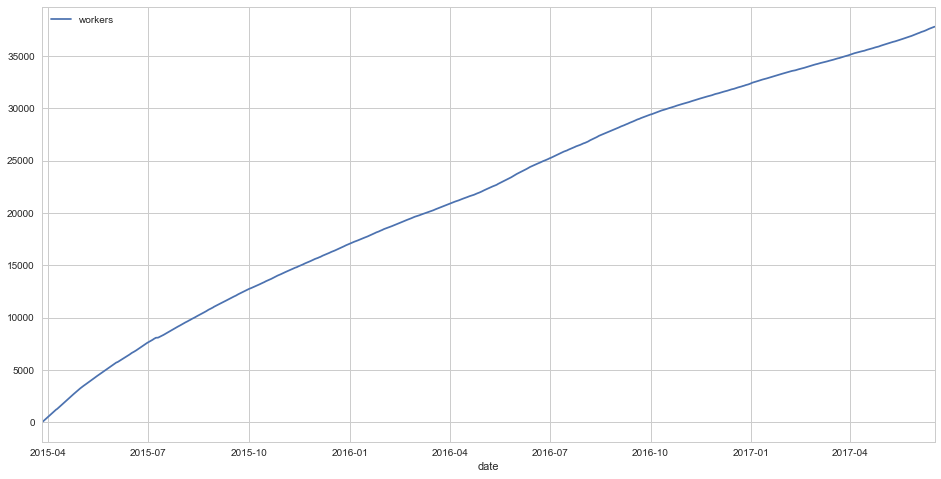

In [7]:
    
workers = pd.DataFrame(results)
workers.set_index('date', inplace = True)
workers.plot()

### Selection bias

The analysis above indicated that we should expect to see around 10K-15K workers on Mechanical Turk, with an average half-life of around a year and a half. Over the last two years, this means around 35K-40K workers total. 

Out of these workers , every month, we survey around $24*4*30 \approx 3K$ workers, for a total of around 80K surveys so far.

If every worker had uniform chance of participating, we would have expected that on average we would see each worker twice.





In [8]:
len(df)

79932

In [9]:
# How often do we see each worker?
df['worker_id'].value_counts()

52629358bb4b600cd895af4db743e93a    34
b2eb9a410e941c1325823ecbceaef077    27
6debc0eceec45c93a8ad66f0359985d2    27
8d581e715b2ca964b55dc6ec3a02f7bc    27
cc15e2c74af011007361cef2b44fd33f    26
b1f852d1ef0dfceda899291ab02cc02a    26
9209bd16839ff33192078642796f4bfe    26
b5dc717d9945a468fb14ae696303ef49    26
d0affb3378f77c9500772f1d90efb7a1    26
1e4879a728be7fae0d8181abaea1130c    26
98a18b3a53eb273babecb5ff88bee6dc    26
e5c4b601c2c07256dc55d8f631f73435    26
f5897a5c69cd5c423a68fa0197ee0494    26
5b044cf509da1d8444b6f60c465240ef    26
1eea49ef4ad993a73014bd8f43a8064f    26
94ecb8b915f9c6b5ed89678d78dba6f1    26
217879bd34b347905ace684b75025c31    26
51ae3104189737180aa3e0bb89f9010c    26
8c4f8c21aeddff5e706d66126195d973    25
9a62370e8624c6a4042f8be623a03bce    25
49f024fa54e56dc620653bac007e88ca    25
8e4ce5263b2b43ec70f532b6d58522f8    25
8c23a41762a5cf37dcf6f9563ea1a054    25
a82df0f35d79cb92b986f092f88854b8    25
2f78fc62fa7c0751776991010210fcdd    25
f04872a22a48af0c0c6bcdf02

In [50]:
# Let's compute the frequency of captures
x = df['worker_id'].value_counts().value_counts()

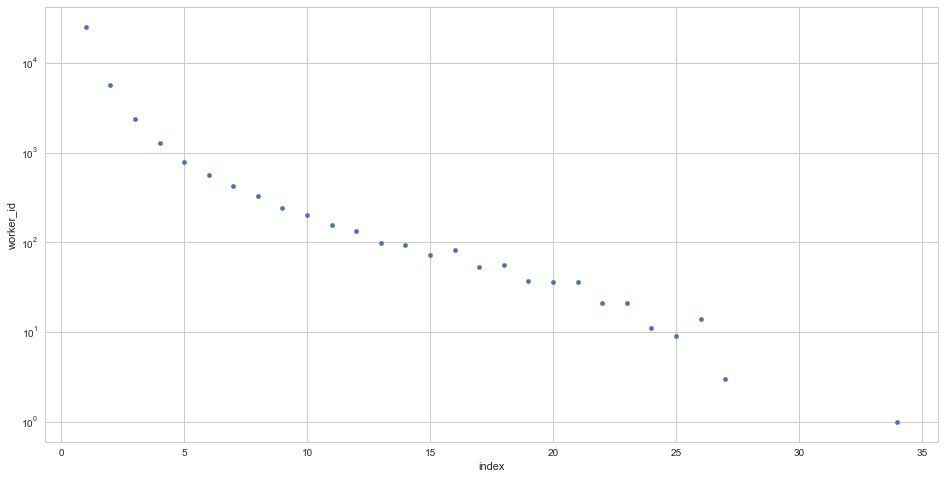

In [51]:
# Plot the above
df['worker_id'].value_counts().value_counts().sort_index().reset_index().plot.scatter(x='index', y='worker_id', logy=True)

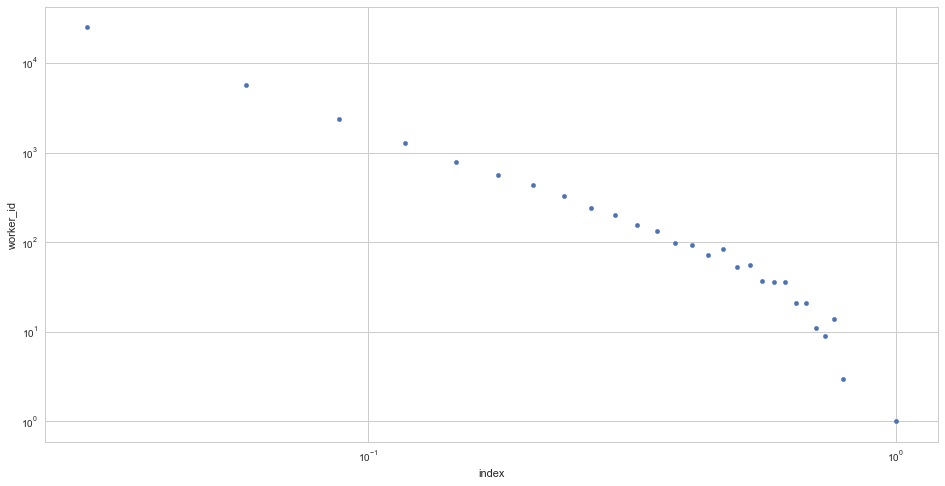

In [52]:
cnt = pd.DataFrame(x).reset_index()
cnt['index'] = cnt['index']/cnt['index'].max()
cnt.plot.scatter(x='index', y='worker_id', logy=True, logx=True)

In [53]:
# Let's try to fit directly a beta distribution on the counts:
import scipy
import random

data = []
mx_freq = max(x.index)
for i,v in x.iteritems():
    tmp = [i/mx_freq] * v
    data.extend(tmp)
    
random.shuffle(data)

scipy.stats.beta.fit(data, scale=1, loc=0)

/usr/local/lib/python3.5/dist-packages/scipy/stats/_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(0.3083476686096705,
 38.474277602014823,
 0.029411764705882349,
 2.4469911900863766)

In [99]:
# We can also try a variety of other distributions and find hte best fit.

import numpy as np
import scipy.stats as st
import statsmodels as sm
import warnings
import sys

# Create models from data
def best_fit_distribution(data, bins=27, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    '''
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    '''
    DISTRIBUTIONS = [        
        st.beta,st.expon,st.exponnorm,st.lognorm,st.lomax,st.powerlaw,st.powerlognorm,st.powernorm
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    #best_p = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # print(distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data, fscale=1)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                #cdf = distribution.cdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                aic = 2*len(params) + np.sum ( distribution.logpdf(data, loc=loc, scale=scale, *arg) )
                #ks = st.kstest(y, cdf)

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse
                    
                print("{0}, [{1}], {2:3,.2f}, {3:3,.2f}".format(distribution.name, params, sse, aic))

        except Exception as e:
            print(sys.exc_info()[0])
            pass

    return (best_distribution.name, best_params)


In [100]:
# Find best fit distribution
best_fit_name, best_fit_paramms = best_fit_distribution(data, 27)
best_dist = getattr(st, best_fit_name)

print("===================")
print(best_fit_name, best_fit_paramms)

beta, [(0.28944199883015281, 20.923782505927392, 0.029411764705882349, 1)], 175.85, 702,768.17
expon, [(0.029411764667400316, 1)], 473.45, -1,234.29
exponnorm, [(0.026545725078731802, 0.035584897868591536, 1)], inf, -34,889.68
lognorm, [(6.6712518578187749, 0.029411764705882349, 1)], 393.30, 480,084.56
lomax, [(33.630562240013106, 0.02941176470584457, 1)], 34.53, 94,040.13
powerlaw, [(0.063487724556662906, 0.029411764705882349, 1)], 394.88, 872,534.82
powerlognorm, [(4.9382013490525276, 9.4931677970797423, 0.029411764705882349, 1)], 421.75, 733,557.75
powernorm, [(41993416.527364962, 5.5575888108134386, 1)], 430.22, 20,180.11
lomax (33.630562240013106, 0.02941176470584457, 1)


In [101]:
# This is from Chao 1987, equation 10.
# This provides a lower bound on the population
# The assumptions in that paper, for the derivation of this estimator are still not great
# as it assumes that the number of captures (sample periods) is large and that probability
# of capture (propensity) is small. This does not work for the right tail (the heavy hitters)

S = 37830
f1 = 25070
f2 = 5642
f3 = 2346
t = 27
m1 = 2 * f2/f1
m2 = 6* f3/f1

N = S + f1**2 / (2*f2) * (( 1 - m1/t)/(1-m2/(t*m1)))
N 

95253.26843134017

In [74]:
# Let's compute the frequency of captures
f = df['worker_id'].value_counts().value_counts()
f = f.drop(34) # dropping the outlier, this is a data point that should not have existed

In [75]:
# If we assume that the distribution of the propensities follows a Beta distribution,
# then the counts will follow a Beta-Binomial distribution
# See https://en.wikipedia.org/wiki/Beta-binomial_distribution


In [76]:
from scipy.special import gammaln
def beta_binom_density_ln(k, n, alpha, beta):
    Ad = beta
    Bd = alpha
    An = n - k + beta
    Bn = k + alpha
    num = gammaln(An) + gammaln(Bn) - gammaln(An+Bn)
    den = gammaln(Ad) + gammaln(Bd) - gammaln(Ad+Bd)    
    log = np.log(scipy.special.comb(n,k)) + num - den
    return np.exp(log)

In [1]:
# Using the method of moments, we can try to fit directly:
# See https://en.wikipedia.org/wiki/Beta-binomial_distribution#Point_estimates

t = max(f.index)
distinct = sum ( [f[i] for i in f.index] )
m1 = sum([ i * f[i] for i in f.index]) / distinct
m2 = sum([ i*i * f[i] for i in f.index]) / distinct
# print(m1, m2)
a = (t * m1 - m2) / (( t * (m2/m1) - m1 -1 ) + m1)
print(a)

b = (t - m1) * ( t  - m2/m1) / (( t * (m2/m1) - m1 -1 ) + m1)
print(b)

NameError: name 'f' is not defined

In [78]:
# This is the probability that a user from the population
# is sampled 0 times
# The one beloe is with the parameters estimated using the method of moments
beta_binom_density_ln(0, t, a, b)

0.50689634635410974

In [104]:
# The one below is estimated through fitting on the MLE estimates for each user
beta_binom_density_ln(0, t, 0.29, 20.9)

0.78403171641375802

In [105]:
# We now need to estimate the value of f[0], which is the number of workers that we have not seen
# That is equal to  beta_binom_density_ln(0, t, a, b) * N
# The remaining workers that we have seen is distinct = N * ( 1-  beta_binom_density_ln(0, t, a, b))

N  = distinct / (1 - beta_binom_density_ln(0, t, a, b))
print(N)

176430.408719


In [106]:
## These are additional estimates based on the difference of the count vs the expected count 
## for various frequencies

import scipy.special
import math

# Fitting on the MLE estimate for each user
a = 0.28
b = 20.1

# Fitting using Method of Moments for Beta-Binomial
a = 0.3
b = 3.6

N_approx = dict()
for i in f.index:
    #print("==========================")
    # e_fi = scipy.special.comb(t, i) * scipy.special.beta(a+i, t-i+b) / scipy.special.beta(a, b)
    e_fi = beta_binom_density_ln(i, t, a, b)
    # print(st.beta.moment(i, a, b))
    # print(e_fi)
    N_approx[i] = f[i]  / e_fi
    print("N_{i:02d} = {approx:10,.2f}". format(i=i, approx=N_approx[i]))
    

N_01 = 194,598.40
N_02 = 118,697.41
N_03 = 115,435.82
N_04 = 136,243.17
N_05 = 180,656.21
N_06 = 273,805.00
N_07 = 443,285.00
N_08 = 719,243.80
N_09 = 1,156,411.94
N_10 = 2,138,558.67
N_11 = 3,833,765.96
N_12 = 7,636,423.81
N_13 = 13,440,623.19
N_14 = 31,791,147.02
N_16 = 199,710,934.75
N_15 = 63,838,177.08
N_18 = 1,167,083,331.00
N_17 = 364,391,260.93
N_19 = 2,502,400,299.32
N_20 = 8,555,784,358.59
N_21 = 33,033,427,775.01
N_22 = 83,338,170,766.46
N_23 = 414,670,987,934.02
N_26 = 135,457,710,183,515.14
N_24 = 1,293,174,988,144.76
N_25 = 8,025,451,336,116.28
N_27 = 599,420,248,830,679.12
